# Learning by Prospective Configuration

Traditionally, artificial neural networks (ANN) are trained with **backpropagation**:  
1. Given inputs and current weights of the ANN, pass forward through the network to get predicted output.
2. Compare the predicted output with true output to get the error and sum to get loss function.  
3. Propagate backwards through the network using gradients of the loss function with respect to weights to adjust the weights (gradient descent).  
4. Neuronal activities on the next forward pass reflect these weight changes.  

An alternative method is proposed in the paper *"Inferring neural activity before plasticity as a foundation for learning beyond backpropagation"* introduces a different principle called **prospective configuration**.

## Intuition

In prospective configuration:
- **Neural activities are updated first**, so that the output neurons already match the target (prospective activity).  
- **Weights are then updated** locally to consolidate this new configuration of activity.  
This reverses the order of steps compared to backpropagation.

Algorithmically we have the training intuition:
1. Hold the input and output layers' activities (value) fixed.
2. Given current weights and each neuron's activity, step through each network layer and compute the error as the difference between the predicted neural activity value and the current stored activity value.
3. Use this error to locally update **(relax)** the weights between consecutive layers iteratively throughout the network.
4. Iterate this process over both your data set and number of epochs.
5. To predict a value, unfix the output layer's activity and relax forward through the network where the output layer gives the prediction.


## Predictive coding formulation

The **energy function** measures the mismatch between predicted and actual activities:

$$
E_l = \tfrac{1}{2}\,\|\,\mathbf{x}_l - W_{l-1} f(\mathbf{x}_{l-1})\,\|^2
$$

where for a ANN of $L$ layers in which layer $l \in \{0,1,...,L\}$ has $n_l\in\mathbb{N}$ neurones:
- Input and output layers of size $n_0,n_L$ respectively.
- $\mathbf{x}_l \in \mathbb{R}^{n_l}$ is the activity (value) of neurons in layer $l$,  
- $W_{l-1} \in \mathbb{R}^{n_l \times n_{l-1}}$ are the weights projecting from layer $l-1 \to l$,  
- $f:\mathbb{R}\mapsto\mathbb{R}$ is a nonlinear, differentiable, activation function e.g. sigmoid, ReLU, tanh 

From this, each layer has a **prediction error**:

$$
\varepsilon_l = \mathbf{x}_l - W_{l-1} f(\mathbf{x}_{l-1})
$$

where $W_{l-1} f(\mathbf{x}_{l-1})$ is the predicition of $\mathbf{x}_l$ by the neurones' of layer $l-1$ activities.
In our code, <code>eps[l] = x[l] - W[l-1] @ f(x[l-1])</code>.


## Neural dynamics (relaxation)

Instead of instantly updating weights, the network **relaxes neuron activities** to reduce energy.  
For hidden layers $l \in \{0,...,L-1\}$ , the update is:

$$
\Delta \mathbf{x}_l = -\gamma \, \varepsilon_l \;+\; f'(\mathbf{x}_l) \odot \left( W_l^\top \, \varepsilon_{l+1} \right)
$$

Or programmatically, <code>dx = -gamma*eps[l] + fprime(x[l]) * (W[l].T @ eps[l+1])</code>. Examining the two above terms we have

1. Error correction from **previous** layer  
The term $-\gamma \varepsilon_l$ pulls the activity $\mathbf{x}_l$ toward the prediction made from the previous layer:
$$
W_{l-1} f(\mathbf{x}_{l-1})
$$
with coefficient $\gamma$ to control the intensity of this pull.

2. Error correction from **subsequent** layer
$$
f'(\mathbf{x}_l) \odot \left(W_l^\top \varepsilon_{l+1}\right)
$$
adjusts $\mathbf{x}_l$ in the direction that would reduce the error at the next layer. To see this we consider the energy in layer $l+1$ and take derivatives
$$
\begin{align*}
E_{l+1} &= \tfrac{1}{2}\,\|\,\varepsilon_{l+1}\,\|^2\\
\frac{\partial E_{l+1}}{\partial \mathbf{x}_l} 
&= \left(\frac{\partial \varepsilon_{l+1}}{\partial \mathbf{x}_l}\right)^\top \varepsilon_{l+1} \\
&= \left(\frac{\partial}{\partial \mathbf{x}_l}\big(\mathbf{x}_{l+1} - W_l f(\mathbf{x}_l)\big)\right)^\top \varepsilon_{l+1} \\
&= \big(-W_l \, \operatorname{diag}(f'(\mathbf{x}_l))\big)^\top \varepsilon_{l+1} \\
&= -\,\operatorname{diag}(f'(\mathbf{x}_l))\, W_l^\top \varepsilon_{l+1} \\
&= -\,f'(\mathbf{x}_l) \odot \big(W_l^\top \varepsilon_{l+1}\big)
\end{align*}
$$

Thus, error can flow backwards from $\varepsilon_{l+1}$ to $\mathbf{x}_{l}$ using the transposed weight matrix $W_l^\top \in \mathbb{R}^{n_{l}\times n_{l+1}}$ and scaled by the activation functions derivative $f'(\mathbf{x}_l)$ using the Hadamard (element-wise) product $\odot$. Therefore, moving $\mathbf{x}_l$ in the direction
$$
-(-f'(\mathbf{x}_l) \odot (W_l^\top \varepsilon_{l+1}))
$$
is equivalent to descending gradients to reduce energy and consequentially $\varepsilon_{l+1}$.

During training, inputs and targets are clamped at the input and output layers. For training data pair $(\mathbf{x},\mathbf{y})$
$$
\begin{cases}
\mathbf{x}_0=\mathbf{x}\\
\mathbf{x}_L=\mathbf{y}
\end{cases}
$$
During prediction, only inputs are clamped, and outputs evolve freely. We repeat this process <code>n_relax_steps</code> times to converge activities to their minimum energy state or their **prospective configuration** for a fixed element of our training data set. 


## Weight update (plasticity)

Once activities have converged to their prospective configuration, weights are updated locally by a Hebbian-like rule:

$$
\Delta W_l = \alpha  \varepsilon_{l+1}  f(\mathbf{x}_l)^\top
$$
$$
W_l \mapsto W_l + \Delta W_l
$$
with
- $\alpha$ is the learning rate,
- $\varepsilon_{l+1}$ is the prediction error at the postsynaptic layer $l+1$.
- $f(\mathbf{x}_l)$ is the presynaptic activity from layer $l$,

This rule reinforces the activity pattern that was just inferred. Hebbian refers to the the psychologist, Donald Hebb, who stated "Neurons that fire together, wire together."

$$
\Delta W_{ij}^{(l)} = \alpha \varepsilon^{(l+1)}_i \, f(\mathbf{x}^{(l)}_j)
$$

Thus
- If a postsynaptic neuron is **under-predicting** $(\varepsilon_i > 0$), the weight increases in proportion to the presynaptic activity — boosting the connection.  
- If a postsynaptic neuron is **over-predicting** ($\varepsilon_i < 0$), the weight decreases — weakening the connection.

In the organic brain, neuromodulators (like dopamine) often mediate whether Hebbian plasticity occurs, depending on whether the outcome is better or worse than predicted. The term $\varepsilon_{l+1}$ plays a similar role here.


In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Activation and derivative
def f(x): return np.tanh(x)
def fprime(x): return 1 - np.tanh(x)**2

class PredictiveCodingNet:
    def __init__(self, sizes, alpha=0.01, gamma=0.1, n_relax_steps=50):
        self.L = len(sizes) - 1
        self.alpha = alpha
        self.gamma = gamma
        self.n_relax_steps = n_relax_steps
        # Initialize random gaussian weights
        self.W = [np.random.randn(sizes[l+1], sizes[l]) * 0.1 for l in range(self.L)]

    def relax(self, x_in, x_out=None):
        
        # Predictive initialization: Initialize activities as zero before doing a standard foward pass 
        x = [np.zeros(size, 1) for size in [w.shape[1] for w in self.W] + [self.W[-1].shape[0]]]
        x[0] = x_in.copy()  # clamp input

        if x_out is not None:
            x[-1] = x_out.copy()  # clamp output

        for _ in range(self.n_relax_steps):
            eps = [None]*(self.L+1)
            for l in range(1, self.L+1):
                x[l]= np.dot(self.W[l],f(x))
                eps[l] = x[l] - self.W[l-1] @ f(x[l-1])

            for l in range(1, self.L+1):
                if l == self.L and x_out is not None:
                    # keep output clamped during training
                    x[l] = x_out.copy()
                else:
                    # update hidden and output (when not clamped)
                    back_term = np.zeros_like(x[l])
                    if l < self.L:  # hidden layer gets top-down error
                        back_term = fprime(x[l]) * (self.W[l].T @ eps[l+1])
                    dx = -self.gamma * eps[l] + back_term
                    x[l] += dx
        
        return x, eps

    def calc_energy(self, x_in, x_out=None):
        # Initialize activities with small random values
        x = [np.random.randn(size, 1) * 0.01 for size in [w.shape[1] for w in self.W] + [self.W[-1].shape[0]]]
        x[0] = x_in.copy()  # clamp input

        if x_out is not None:
            x[-1] = x_out.copy()  # clamp output
            
        E = 0
        eps = [None]*(self.L+1)
        for l in range(1, self.L+1):
            eps[l] = x[l] - self.W[l-1] @ f(x[l-1])
            E += 0.5 * np.dot(eps[l].flatten(),eps[l].flatten())

        return E,eps
        
    
    def train_step(self, x_in, x_target):
        x, eps = self.relax(x_in, x_target)
        for l in range(self.L):
            self.W[l] += self.alpha * eps[l+1] @ f(x[l]).T
        

    def predict(self, x_in):
        x, _ = self.relax(x_in, None)
        return x[-1]

    def forward(self, x_in):
        x=x_in
        for l in range(self.L):
            x = np.dot(self.W[l],f(x))
        return x
            


# ---- Example: Learn sine wave ----
net = PredictiveCodingNet([1,20,20,1],alpha=0.01, gamma=0.005, n_relax_steps=30)
xs = np.linspace(-np.pi, np.pi, 200).reshape(-1, 1, 1)
ys = np.sin(xs)

In [37]:
net.forward(xs.reshape(1,-1))

array([[ 3.51401965e-04,  3.51352370e-04,  3.51299527e-04,
         3.51243222e-04,  3.51183227e-04,  3.51119300e-04,
         3.51051181e-04,  3.50978593e-04,  3.50901242e-04,
         3.50818813e-04,  3.50730970e-04,  3.50637355e-04,
         3.50537585e-04,  3.50431253e-04,  3.50317923e-04,
         3.50197129e-04,  3.50068376e-04,  3.49931134e-04,
         3.49784837e-04,  3.49628880e-04,  3.49462618e-04,
         3.49285361e-04,  3.49096371e-04,  3.48894863e-04,
         3.48679993e-04,  3.48450862e-04,  3.48206508e-04,
         3.47945904e-04,  3.47667947e-04,  3.47371463e-04,
         3.47055193e-04,  3.46717788e-04,  3.46357809e-04,
         3.45973713e-04,  3.45563849e-04,  3.45126448e-04,
         3.44659617e-04,  3.44161330e-04,  3.43629416e-04,
         3.43061550e-04,  3.42455241e-04,  3.41807821e-04,
         3.41116435e-04,  3.40378020e-04,  3.39589299e-04,
         3.38746763e-04,  3.37846654e-04,  3.36884947e-04,
         3.35857338e-04,  3.34759222e-04,  3.33585674e-0

In [38]:


# Training

for epoch in range(400):
    E_sum = 0
    for i in range(len(xs)):
        net.train_step(xs[i], ys[i])
        E,eps = net.calc_energy(xs[i], ys[i])
        E_sum += E
    print(E)
    



1.7885508210479466
2.0022920740472614
1.835365798345794
1.6558269037488969
1.5325338112153535
1.4168934814217593
1.3347854316906937
1.2723659972477448
1.235388252016529
1.1939226886152237
1.1398823083701632
1.1122230674161808
1.0882635671062115
1.0661543038323007
1.0263342732709206
1.0209405215262963
1.006757833022202
0.992640176249095
0.9518016823065136
0.9355769155630757
0.9331899083818369
0.8939095424870533
0.9186639985309034
0.8817869275977128
0.880928148765001
0.860065489816173
0.8390068680146225
0.8488313599014793
0.8398049251228804
0.8279104570945028
0.8146282809055498
0.8261663401761893
0.8135912930926662
0.8053774731740414
0.807368686015404
0.7670585605915784
0.7701921363698467
0.7681313630015704
0.7316622435483605
0.7552191237889412
0.7351580161221954
0.7549137686463913
0.7403713186823027
0.7284222170949609
0.7276822937868138
0.6969705219663517
0.7206158731572698
0.7018474134888858
0.7063342713475439
0.6981219538631608
0.6666863677717518
0.704805554324364
0.6769615616008866
0

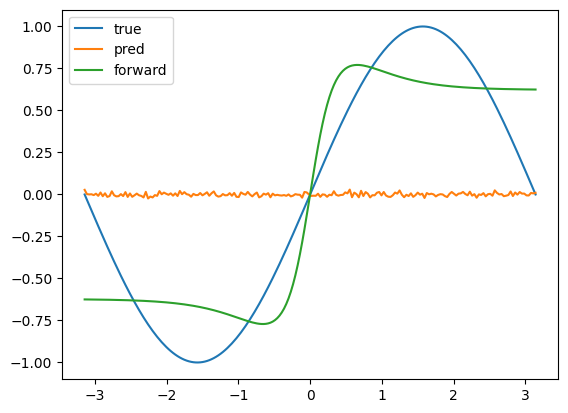

In [39]:
# Prediction
# Training

#for i in range(len(xs)):
#    net.train_step(xs[i], ys[i])

y_pred = np.array([net.predict(x)[0,0] for x in xs])
y_forward = net.forward(xs.reshape(1,-1)).flatten()
    

plt.plot(xs.squeeze(), ys.squeeze(), label="true")
plt.plot(xs.squeeze(), y_pred, label="pred")
plt.plot(xs.squeeze(), y_forward, label="forward")
plt.legend()
plt.show()